In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# set different font to display korean characters
import matplotlib.font_manager as fm
fprop = fm.FontProperties(family='AppleGothic') # font from matplotlib inbuild

# to ignore plt warnings, not good practice but makes things neat and pretty for presentation purposes
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
# set different font to display korean characters; seaborn uses same set as matplotlib
sns.set(style='whitegrid', font='AppleGothic', rc={'figure.figsize':(10,5)})
sns.set_palette(palette='muted')

import nltk

# own utility modules
import mods.text as text
import mods.lyrics as lyrics
import replacements as replacements

# 0. Data Pre-Processing

In [2]:
# read data
raw = pd.read_csv('./data/lyrics.csv', encoding='utf8')
df = raw.copy()

# set column types
df['album_rd'] = df['album_rd'].astype('datetime64[ns]')

# add column to reflect year track is released in df
df['year'] = df['album_rd'].dt.year

# copy of df before filtering
unfiltered_df = df.copy()

# remove album extras (not tracks)
no_skits = df[~df['track_title'].str.contains('notes', case=False) & ~df['track_title'].str.contains('skit', case=False)]

# remove duplicate tracks (non-repackaged, not remix, not short versions)
unique_tracks = no_skits[~no_skits['repackaged'] & ~no_skits['remix'] & ~no_skits['has_full_ver']]

# fill null with "NA"
df = df.fillna('NA')

df.columns

Index(['id', 'album_title', 'eng_album_title', 'album_rd', 'album_seq',
       'track_title', 'kor_track_title', 'eng_track_title', 'lyrics',
       'hidden_track', 'remix', 'featured', 'performed_by', 'repackaged',
       'lang', 'has_full_ver', 'year'],
      dtype='object')

# 1. Exploratory Data Analysis (EDA)

## 1.1 General 

### 1.1.1 By Year

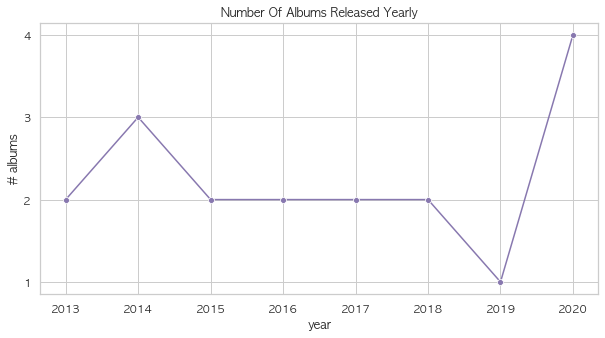

<Figure size 720x360 with 0 Axes>

In [3]:
temp = unfiltered_df.copy()[['album_title', 'year']]
temp = temp.drop_duplicates(subset='album_title')
temp = temp.groupby(by='year', as_index=False).agg({
    'album_title': 'count'
}).sort_values(by=['year'])

# plot
# set y-axis labels to be only integers
plt.yticks(range(min(temp['album_title']), max(temp['album_title'])+1))
ax = sns.lineplot(x='year', y='album_title', marker='8', data=temp, sort=False, color='#8878af')
ax.set(xlabel='year', ylabel='# albums', title='Number Of Albums Released Yearly')
plt.show()

# save plot as png
plt.savefig('plots/num_albums_yearly_line.png', bbox_inches='tight')

Exploring the different visualisations: line vs bar

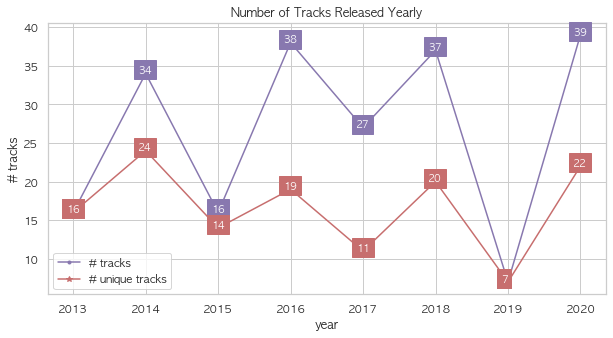

In [4]:
total = no_skits.copy()[['track_title', 'year']]
total = total.groupby(by='year', as_index=False).agg({
    'track_title': 'count'
    }).sort_values(by=['year'])
total = total.rename(columns={
    'track_title': 'total_tracks'
})

unique = unique_tracks.copy()[['track_title', 'year']]
unique = unique.groupby(by='year', as_index=False).agg({
    'track_title': 'count'
    }).sort_values(by=['year'])
unique = unique.rename(columns={
    'track_title': 'unique_tracks'
})
combined = total.merge(unique, on='year')

# plot
plt.title('Number of Tracks Released Yearly')
plt.ylabel('# tracks')
plt.xlabel('year')
plt.plot('year', 'total_tracks', data=combined, marker='.', color='#8878af', label='# tracks')
plt.plot('year', 'unique_tracks', data=combined, marker='*', color='#c76e6e', label='# unique tracks')
plt.legend(loc='lower left')

# add data labels
for x, y1, y2 in zip(combined['year'], combined['total_tracks'], combined['unique_tracks']):
    plt.text(x-0.1, y1, y1, color='white', size='small').set_backgroundcolor('#8878af')
    plt.text(x-0.1, y2, y2, color='white', size='small').set_backgroundcolor('#c76e6e')

# save plot as png
plt.savefig('plots/num_tracks_yearly_line.png')

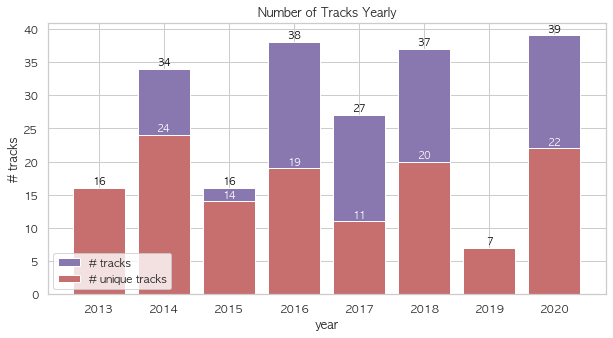

In [5]:
total = no_skits.copy()[['track_title', 'year']]
total = total.groupby(by='year', as_index=False).agg({
    'track_title': 'count'
    }).sort_values(by=['year'])
total = total.rename(columns={
    'track_title': 'total_tracks'
})

unique = unique_tracks.copy()[['track_title', 'year']]
unique = unique.groupby(by='year', as_index=False).agg({
    'track_title': 'count'
    }).sort_values(by=['year'])
unique = unique.rename(columns={
    'track_title': 'unique_tracks'
})
combined = total.merge(unique, on='year')

# plot
plt.title('Number of Tracks Yearly')
plt.ylabel('# tracks')
plt.xlabel('year')
plt.bar('year', 'total_tracks', data=combined, color='#8878af', label='# tracks')
plt.bar('year', 'unique_tracks', data=combined, color='#c76e6e', label='# unique tracks')
plt.legend(loc='lower left')

# add data labels
for x, y1, y2 in zip(combined['year'], combined['total_tracks'], combined['unique_tracks']):
    plt.text(x, y2+0.5, y2, ha='center', color='white', size='small')
    plt.text(x, y1+0.5, y1, ha='center', color='black', size='small')

# save plot as png
plt.savefig('plots/num_tracks_yearly_bar.png')

the bar plot show with more clarity the disparity between the total number of tracks vs the number of unique tracks.

### 1.1.2 By Album

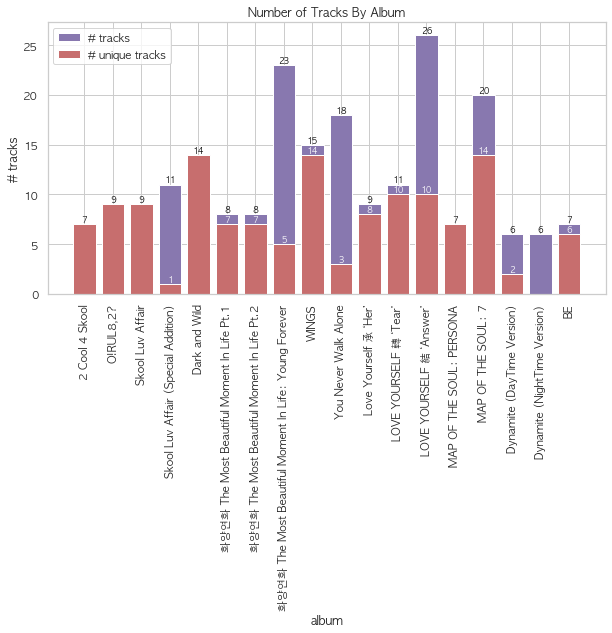

In [6]:
# grouping by total number of tracks
total = no_skits.copy()[['album_title','track_title', 'id']]
total = total.groupby(by='album_title', as_index=False).agg({
    'track_title': 'count',
    'id': 'min'
    }).sort_values(by=['id'])
total = total.rename(columns={
    'track_title': 'total_tracks'
})

# grouping by unique tracks
unique = unique_tracks.copy()[['album_title','track_title', 'id']]
unique = unique.groupby(by='album_title', as_index=False).agg({
    'track_title': 'count',
    'id': 'min'
    }).sort_values(by=['id'])
unique = unique.rename(columns={
    'track_title': 'unique_tracks'
})

# combine the total and unique dataframes
combined = total.merge(unique, on='album_title')
combined = combined.drop(columns='id_y')
combined = combined.rename(columns={'id_x': 'id'})

# no merging of dfs, on assumption that the number of years in both total and unique dfs are the same, cos they are supposed to be

# plot
plt.title('Number of Tracks By Album')
plt.ylabel('# tracks')
plt.xlabel('album')
plt.xticks(rotation=90)
plt.bar('album_title', 'total_tracks', data=total, color='#8878af', label='# tracks')
plt.bar('album_title', 'unique_tracks', data=unique, color='#c76e6e', label='# unique tracks')

plt.legend(loc='upper left')

# add data labels
for x, y1, y2 in zip(combined['album_title'], combined['total_tracks'], combined['unique_tracks']):
    plt.text(x, y2+0.2, y2, ha='center', size='x-small', color='white')
    plt.text(x, y1+0.2, y1, ha='center', size='x-small', color='black')

# line of its own cos the loop above skips it
plt.text ('Dynamite (NightTime Version)', 6.2, 6, ha='center', size='x-small', color='black')

# save plot as png
plt.savefig('plots/num_tracks_album_bar.png', bbox_inches='tight')

# 2. Lyrics

In [7]:
# add column with number of words in lyrics for each track
no_skits['lyrics'] = no_skits.lyrics.apply(str)
no_skits['num_words'] = no_skits['lyrics'].apply(lambda x: len(x.split()))

## 2.1 Lyric Word Count

### 2.1.1 Distribution Of Word Count

median: 456.0


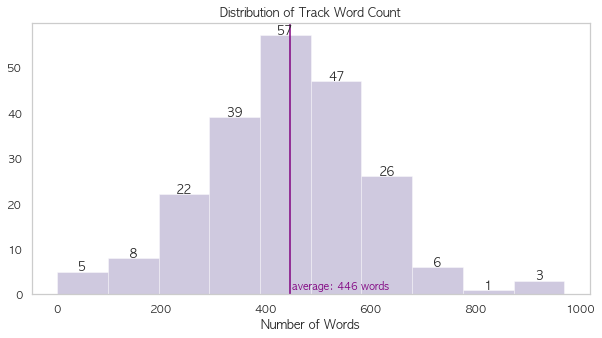

In [8]:
# plot distribution plot
ax = sns.distplot(no_skits['num_words'], color='#8878af', bins=10, kde=False)
ax.set(xlabel='Number of Words', title='Distribution of Track Word Count')
ax.grid(False) # not display grids

# plot average line
mean_words = no_skits['num_words'].mean()
plt.axvline(mean_words, color='purple', label='mean')
plt.text(mean_words+3, 1, 'average: {:.0f} words'.format(mean_words), color='purple', size='small', weight='bold')
# print('mean num_words: {:.2f}'.format(mean_words))

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+(p.get_width()/2),
            height + 0.2,
            '{:.0f}'.format(height),
            ha='center')

# save plot as png
plt.savefig('plots/distribution_word_count.png', bbox_inches='tight')

median_words = no_skits['num_words'].median()
print('median: {}'.format(median_words))

### 2.1.2 Average Words Per Unique Track Yearly

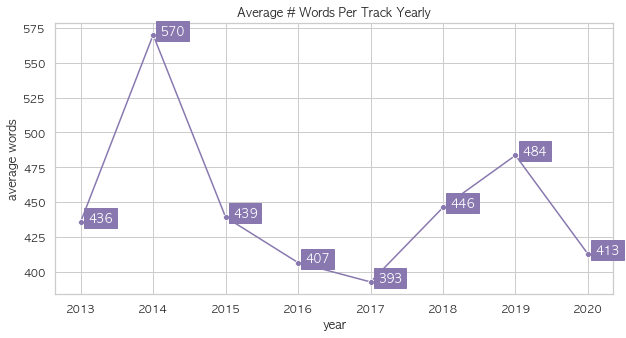

In [9]:
years = pd.DataFrame({'num_words_sum' : no_skits.groupby('year')['num_words'].sum(),
                      'track_count': no_skits.groupby('year').size(),
                      'album_count': no_skits.groupby('year')['album_title'].nunique()
                      })
years = years.reset_index()
years['avg_words'] = years.apply(lambda x: x.num_words_sum / x.track_count,  axis=1)

# plot
ax = sns.lineplot(x='year', y='avg_words', marker='8', data=years, sort=False, color='#8878af')
ax.set(xlabel='year', ylabel='average words', title='Average # Words Per Track Yearly')

# label points on plot
for x, y in zip(years['year'], years['avg_words']):
    plt.text(x+0.1, y, '{:.0f}'.format(y), color='white').set_backgroundcolor('#8878af')

# save plot as png
plt.savefig('plots/avg_words_per_track_yearly.png', bbox_inches='tight')

### 2.1.3 Average Words Per Unique Track By Album

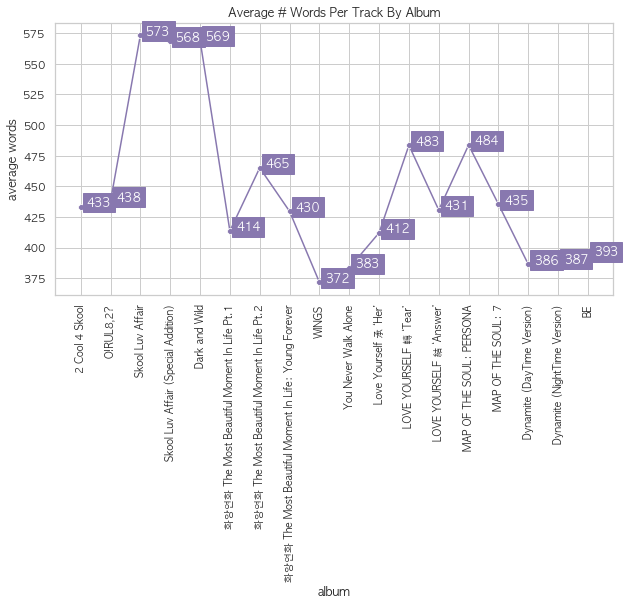

In [10]:
temp = pd.DataFrame({'num_words_sum' : no_skits.groupby('album_title')['num_words'].sum(),
                      'track_count': no_skits.groupby('album_title').size(),
                      'album_count': no_skits.groupby('album_title')['album_title'].nunique(),
                      'id': no_skits.groupby('album_title')['id'].min()
                      }).sort_values(by='id')
temp = temp.reset_index()
temp['avg_words'] = temp.apply(lambda x: x.num_words_sum / x.track_count,  axis=1)

# plot
ax = sns.lineplot(x='album_title', y='avg_words', marker='8', data=temp, sort=False, color='#8878af')
ax.set(xlabel='album', ylabel='average words', title='Average # Words Per Track By Album')
plt.xticks(rotation=90)
ax.set_xticklabels(list(temp['album_title']), fontproperties=fprop)

# label data points
for x, y in zip(range(0, len(temp['album_title'])), temp['avg_words']):
    plt.text(x+0.2, y, '{:.0f}'.format(y), color='white').set_backgroundcolor('#8878af')

# save plot as png
plt.savefig('plots/avg_words_per_track_album.png', bbox_inches='tight')

### 2.1.4 Most Common Words

In [11]:
from collections import Counter
total_words = no_skits['num_words'].sum()
temp = pd.DataFrame(data=Counter(' '.join(df['lyrics']).split()).most_common(20),
                columns=['word', 'count'])
# format to 2 decimal places with % sign, purely for display, not recommended if further analysis is going to be done on percentage column
temp['percentage'] = temp['count'].apply(lambda c: '{0:.2f}%'.format(c/total_words))
temp

,word,count,percentage
0,i,4271,0.04%
1,the,3459,0.04%
2,you,3063,0.03%
3,my,1959,0.02%
4,to,1931,0.02%
5,a,1749,0.02%
6,me,1584,0.02%
7,it,1402,0.01%
8,and,1360,0.01%
9,of,1270,0.01%


### 2.1.5 Word Cloud

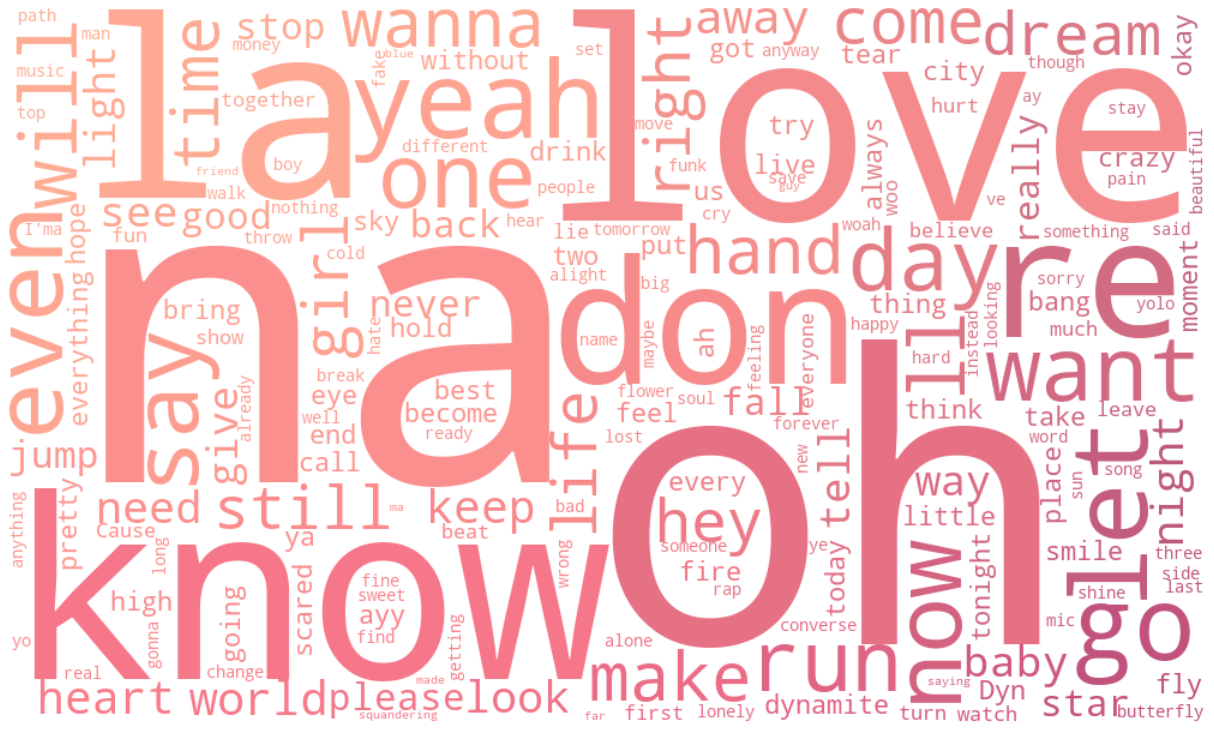

In [12]:
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

all_lyrics = ' '.join(list(no_skits['lyrics']))

wordcloud = WordCloud(width = 1000, height = 600, 
                      background_color ='white', 
                      collocations=False,
                      min_font_size = 10).generate(all_lyrics)

# image mask to colour wordcloud
mask = np.array(Image.open("img/purple-gradient.png"))
image_colors = ImageColorGenerator(mask)

# plot the WordCloud image                        
plt.figure(figsize = (20, 10), facecolor = None) 
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear") 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# to save image (using pillow)
image = wordcloud.to_image()
image.save('plots/word_cloud.png')

### 2.1.6 Most Common Bi-grams

In [13]:
bigrams = nltk.bigrams(' '.join(df['lyrics']).split())
temp = pd.DataFrame(data=Counter(bigrams).most_common(20),
            columns=['bigram', 'count'])
# remove tuple brackets from display
temp['bigram'] = temp['bigram'].apply(lambda b: ' '.join(b))
temp

,bigram,count
0,la la,402
1,in the,298
2,i want,208
3,i can’t,185
4,want to,182
5,i was,181
6,of the,179
7,when i,174
8,like a,171
9,even if,168


### 2.1.7 Most Common Tri-grams

In [14]:
trigrams = nltk.trigrams(' '.join(df['lyrics']).split())
temp = pd.DataFrame(data=Counter(trigrams).most_common(20),
            columns=['trigram', 'count'])
# remove tuple brackets from display
temp['trigram'] = temp['trigram'].apply(lambda b: ' '.join(b))
temp

,trigram,count
0,la la la,332
1,i want to,129
2,i need you,100
3,oh oh oh,89
4,it up like,87
5,need you girl,72
6,the stars tonight,72
7,"Dyn-na-na-na, na-na, na-na,",72
8,"na-na, na-na, ayy",72
9,in the stars,71


### 2.1.8 Top 10 Tracks - Most Number Of Words

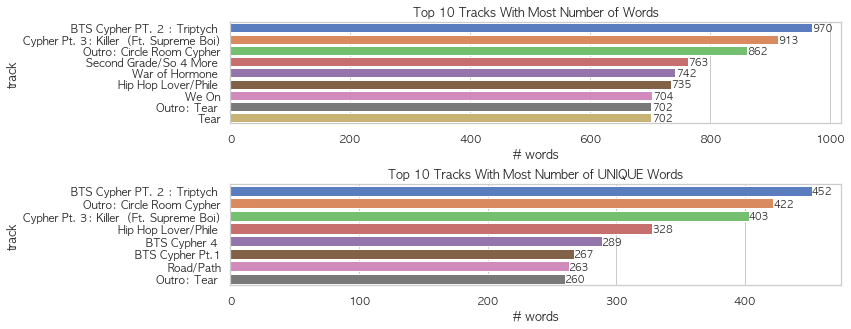

<Figure size 7200x1440 with 0 Axes>

In [15]:
# sorts dataframe rows according to num_words (descending)
top10words = no_skits.sort_values('num_words', ascending=False).head(10)

# add column with number of unique words in lyrics for each track
no_skits['num_unique'] = no_skits['lyrics'].apply(lambda x: len(set(x.split())))

# sorts dataframe rows according to num_unique (descending)
top10unique = no_skits.sort_values('num_unique', ascending=False).head(10)

# plot
fig, axs = plt.subplots(nrows=2)
plt.figure(figsize=(100,20))
fig.tight_layout(pad=3)
sns.barplot(x='num_words', y='eng_track_title', data=top10words, ax=axs[0])
sns.barplot(x='num_unique', y='eng_track_title', data=top10unique, ax=axs[1])
axs[0].set(xlabel='# words', ylabel='track', title='Top 10 Tracks With Most Number of Words')
axs[1].set(xlabel='# words', ylabel='track', title='Top 10 Tracks With Most Number of UNIQUE Words')

# add data labels
for p1 in axs[0].patches:
    width1 = p1.get_width()
    axs[0].text(x=width1+18, y=p1.get_y() + p1.get_height()/2., s='{:.0f}'.format(width1), ha='center', va='center', fontsize='small')

for p2 in axs[1].patches:
    width2 = p2.get_width()
    axs[1].text(x=width2+8, y=p2.get_y() + p2.get_height()/2., s='{:.0f}'.format(width2), ha='center', va='center', fontsize='small')

# save plot as png
plt.savefig('plots/top10_tracks_words.png', bbox_inches='tight')

### 2.1.9 Top 10 Tracks - Least Number Of Words

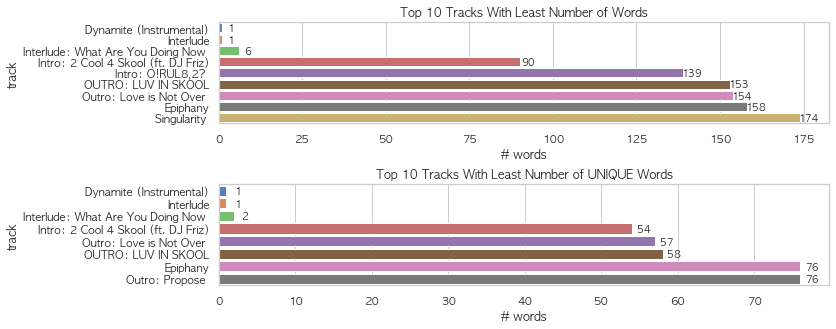

<Figure size 7200x1440 with 0 Axes>

In [16]:
# sorts dataframe rows according to num_words (ascending)
bottom10words = no_skits.sort_values('num_words', ascending=True).head(10)
bottom10unique = no_skits.sort_values('num_unique').head(10)

# plot
fig, axs = plt.subplots(nrows=2)
plt.figure(figsize=(100,20))
fig.tight_layout(pad=3)
sns.barplot(x='num_words', y='eng_track_title', data=bottom10words, ax=axs[0])
sns.barplot(x='num_unique', y='eng_track_title', data=bottom10unique, ax=axs[1])
axs[0].set(xlabel='# words', ylabel='track', title='Top 10 Tracks With Least Number of Words')
axs[1].set(xlabel='# words', ylabel='track', title='Top 10 Tracks With Least Number of UNIQUE Words')

# add data labels
for p1 in axs[0].patches:
    width1 = p1.get_width()
    axs[0].text(x=width1+2.5, y=p1.get_y() + p1.get_height()/2., s='{:.0f}'.format(width1), ha='center', va='center', fontsize='small')

for p2 in axs[1].patches:
    width2 = p2.get_width()
    axs[1].text(x=width2+1.5, y=p2.get_y() + p2.get_height()/2., s='{:.0f}'.format(width2), ha='center', va='center', fontsize='small')

# save plot as png
plt.savefig('plots/bottom10_tracks_words.png', bbox_inches='tight')

## 2.2 Words of Interest in Lyrics

* Significance measured using [TF-IDF](https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting), which gives a higher weightage to less common (hence, more meaningful and "interesting") words 

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

album_lyrics = no_skits['lyrics']

### 2.2.1 Top 20 Most Interesting Words In All Lyrics

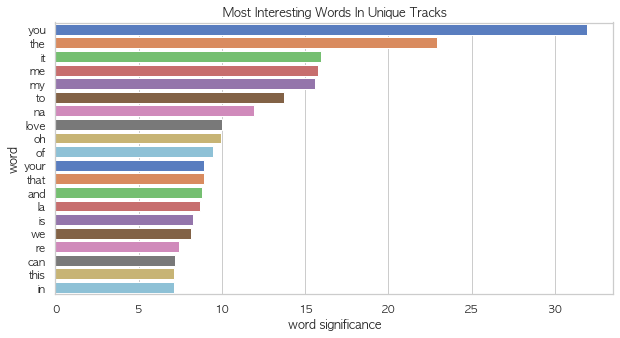

In [18]:
lyr = list(album_lyrics.apply(pd.Series).stack())
tf = tfidf.fit_transform(lyr)
words = tfidf.get_feature_names()
tf_df = pd.DataFrame(tf.toarray(), columns= words)
head = tf_df.sum().sort_values(ascending=False)[:20]
ax = sns.barplot(head.values, head.index, orient = 'h', palette='muted')
ax.set(xlabel='Term Frequency', title='Most Interesting Words In Unique Tracks')
ax.set_ylabel('word')
ax.set_xlabel('word significance')

# save plot as png
plt.savefig('plots/top20_interesting_words_all.png', bbox_inches='tight')

### 2.2.2 Top 10 Most Interesting Words Lyrics In Each Album

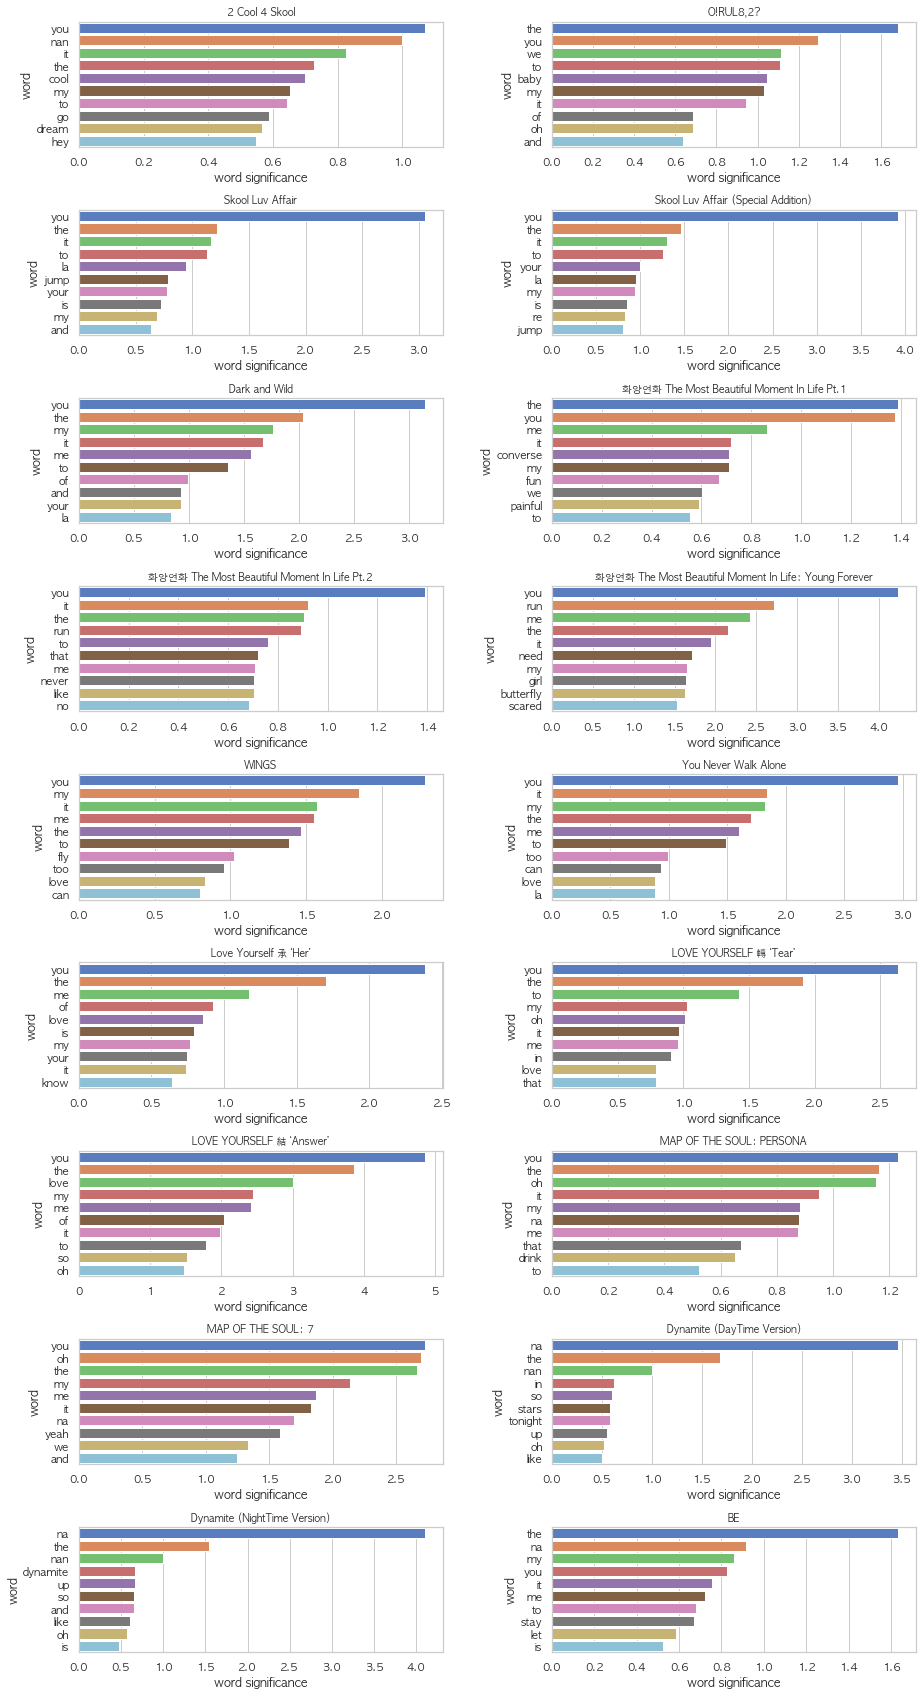

In [19]:
albums = list(df['album_title'].unique())

fig, axs = plt.subplots(int(len(albums)/2),2, figsize=(15, 30))
fig.subplots_adjust(hspace = .5, wspace=.3)
axs = axs.ravel()

for i, title in enumerate(albums):
    album_lyrics = no_skits[no_skits['album_title'] == title]['lyrics']
    lyr = list(album_lyrics.apply(pd.Series).stack())
    tf = tfidf.fit_transform(lyr)
    words = tfidf.get_feature_names()
    tf_df = pd.DataFrame(tf.toarray(), columns= words)
    head = tf_df.sum().sort_values(ascending=False)[:10]
    sns.barplot(head.values, head.index, orient = 'h', palette = 'muted', ax = axs[i])
    axs[i].set_title(title, fontproperties=fprop)
    axs[i].set_ylabel('word')
    axs[i].set_xlabel('word significance')
    
#deleting last plot bc odd number of albums
# fig.delaxes(axs[i+1])

# save plot as png
plt.savefig('plots/top10_interesting_words_album.png', bbox_inches='tight')